# Predicting Flight Delay

This notebook is derived and inspired by this kaggle kernel : https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial/

The US Department of Transportation has been releasing their data on interstate and local flights in their website. They also released a compiled 2015 data on [Kaggle](https://www.kaggle.com/usdot/flight-delays) and framed the task on delay prediction. The data is large, even for just a year.

I aim to do this using PySpark to further deepen my skill in Spark and Data Science. Throughout the notebook, I will be going back and forth between Spark and Pandas to analyze the data before stepping into modelling.

Let's start by loading the csv file to spark. First, tell findspark to retrieve the location of our Spark instance. This would be done without any problem if you have your `SPARK_HOME` system variable set properly

In [1]:
import findspark
findspark.init()

Then we need to create a spark session to load our data. Since inferred schema in Spark only allows for string, we need to define each field's schema manually.

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.sql.warehouse.dir", "file:///G:/temp").appName("FlightDelay").getOrCreate()

flights_sdf = spark.read.option("header",True).schema('YEAR integer, MONTH integer, DAY integer, DAY_OF_WEEK integer, AIRLINE string, FLIGHT_NUMBER string, \
TAIL_NUMBER string, ORIGIN_AIRPORT string, DESTINATION_AIRPORT string, SCHEDULED_DEPARTURE string, DEPARTURE_TIME string, \
DEPARTURE_DELAY integer, TAXI_OUT integer, WHEELS_OFF string, SCHEDULED_TIME integer, ELAPSED_TIME string, AIR_TIME integer, \
DISTANCE integer, WHEELS_ON string, TAXI_IN integer, SCHEDULED_ARRIVAL string, ARRIVAL_TIME string, ARRIVAL_DELAY integer, \
DIVERTED integer, CANCELLED integer, CANCELLATION_REASON string, AIR_SYSTEM_DELAY integer, SECURITY_DELAY integer, \
AIRLINE_DELAY integer, LATE_AIRCRAFT_DELAY integer, WEATHER_DELAY integer').csv("flights.csv")
flights_sdf.createOrReplaceTempView('flights')

airlines_sdf = spark.read.option("header",True).csv("airlines.csv")
airlines_sdf.createOrReplaceTempView('airlines')

airports_sdf = spark.read.option("header",True).csv("airports.csv")
airports_sdf.createOrReplaceTempView('airports')

Let's see how big these data are. Since they're already in a view, we can easily do SQL query to them, and therefore some simple aggregation.

In [3]:
spark.sql("SELECT count(*) from flights").show()

spark.sql("SELECT count(*) from airlines").show()

spark.sql("SELECT count(*) from airports").show()

+--------+
|count(1)|
+--------+
| 5819079|
+--------+

+--------+
|count(1)|
+--------+
|      14|
+--------+

+--------+
|count(1)|
+--------+
|     322|
+--------+



Yikes. . . almost 6 million rows. Analyzing all of it at the same time would take long in most python statistics library. Let's sample some rows, say. . . about 10%, so 600000 rows, that's more managable for analysis. We'll filter out diverted and cancelled flights, since those are not of our concern as of now.

In [4]:
flights_sdf = spark.sql("select * from flights where DIVERTED = 0 and cancelled = 0")
flights_sdf.createOrReplaceTempView('flights')

We also need to fix some bad IATA codes in origin and destination airports. In the month of October, it seems that the data entry gets a bit buggy on their side. As described in this discussion : https://www.kaggle.com/usdot/flight-delays/discussion/39118

In [5]:
airports_id = spark.read.option("header",True).csv("L_AIRPORT_ID.csv")
airports_id.createOrReplaceTempView('airports_id')

airports_iata = spark.read.option("header",True).csv("L_AIRPORT.csv")
airports_iata.createOrReplaceTempView('iata')

spark.sql('select \
aid.Code as id, \
iata.code as iata_code, \
aid.Description as description \
from airports_id aid left join iata on iata.description = aid.description').createOrReplaceTempView('airports_master')

spark.sql("select f.*, \
oam.iata_code as ORIGIN_AIRPORT_FIXED, \
dam.iata_code as DESTINATION_AIRPORT_FIXED \
from flights f \
left join airports_master oam on oam.id = f.ORIGIN_AIRPORT \
left join airports_master dam on dam.id = f.DESTINATION_AIRPORT").createOrReplaceTempView('flights_with_fix')

flights_sdf = spark.sql("SELECT YEAR, \
MONTH, \
DAY, \
DAY_OF_WEEK, \
AIRLINE, \
FLIGHT_NUMBER, \
TAIL_NUMBER, \
CASE \
WHEN ORIGIN_AIRPORT_FIXED IS NOT NULL THEN ORIGIN_AIRPORT_FIXED \
ELSE ORIGIN_AIRPORT \
END AS ORIGIN_AIRPORT, \
CASE \
WHEN DESTINATION_AIRPORT_FIXED IS NOT NULL THEN DESTINATION_AIRPORT_FIXED \
ELSE DESTINATION_AIRPORT \
END AS DESTINATION_AIRPORT, \
SCHEDULED_DEPARTURE, \
DEPARTURE_TIME, \
DEPARTURE_DELAY, \
TAXI_OUT, \
WHEELS_OFF, \
SCHEDULED_TIME, \
ELAPSED_TIME, \
AIR_TIME, \
DISTANCE, \
WHEELS_ON, \
TAXI_IN, \
SCHEDULED_ARRIVAL, \
ARRIVAL_TIME, \
ARRIVAL_DELAY, \
DIVERTED, \
CANCELLED, \
CANCELLATION_REASON, \
AIR_SYSTEM_DELAY, \
SECURITY_DELAY, \
AIRLINE_DELAY, \
LATE_AIRCRAFT_DELAY, \
WEATHER_DELAY FROM flights_with_fix")

flights_sdf.createOrReplaceTempView('flights')

And then we can sample the correct data for our analysis.

In [6]:
sampled_flights = flights_sdf.sample(False, 0.1, 42)
sampled_flights.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: string (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: string (nullable = true)
 |-- DEPARTURE_TIME: string (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: string (nullable = true)
 |-- ARRIVAL_TIME: string (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = t

Now that we have a downsampled data, let's switch to pandas to do some EDA and maybe figure out some feature engineering. Later, we will mimic what we do in pandas to spark for handling bigger data.

In [7]:
flights_df = sampled_flights.toPandas()
airlines_df = airlines_sdf.toPandas()
airports_df = airports_sdf.toPandas()

In [8]:
flights_df.head(10)

YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      2    5            4      EV          5239      N857AS   
1  2015      2   11            3      EV          5239      N855AS   
2  2015      2   12            4      EV          5239      N933EV   
3  2015      6   12            5      EV          5172      N927EV   
4  2015      6   17            3      EV          5172      N979EV   
5  2015      6   20            6      EV          5250      N878AS   
6  2015      6   22            1      EV          5212      N922EV   
7  2015      6   26            5      EV          5212      N839AS   
8  2015      7    1            3      EV          4910      N856AS   
9  2015      7    6            1      EV          4910      N916EV   

  ORIGIN_AIRPORT DESTINATION_AIRPORT SCHEDULED_DEPARTURE  ... ARRIVAL_TIME  \
0            DTW                 BGM                2145  ...         2303   
1            DTW                 BGM                2145  ...         0044   
2            DTW                 BGM                2145  ...         2250   
3            DTW                 BGM                2146  ...         2336   
4            DTW                 BGM                2146  ...         2304   
5            DTW                 BGM                1345  ...         1447   
6            DTW                 BGM                1345  ...         1623   
7            DTW                 BGM                1345  ...         1456   
8            DTW                 BGM                2145  ...         2320   
9            DTW                 BGM                2135  ...         2255   

   ARRIVAL_DELAY  DIVERTED CANCELLED  CANCELLATION_REASON AIR_SYSTEM_DELAY  \
0             -8         0         0                 None              NaN   
1             93         0         0                 None              0.0   
2            -21         0         0                 None              NaN   
3             27         0         0                 None              0.0   
4             -5         0         0                 None              NaN   
5            -20         0         0                 None              NaN   
6             76         0         0                 None              0.0   
7            -11         0         0                 None              NaN   
8             12         0         0                 None              NaN   
9              4         0         0                 None              NaN   

   SECURITY_DELAY  AIRLINE_DELAY LATE_AIRCRAFT_DELAY  WEATHER_DELAY  
0             NaN            NaN                 NaN            NaN  
1             0.0            0.0                93.0            0.0  
2             NaN            NaN                 NaN            NaN  
3             0.0            0.0                27.0            0.0  
4             NaN            NaN                 NaN            NaN  
5             NaN            NaN                 NaN            NaN  
6             0.0           60.0                16.0            0.0  
7             NaN            NaN                 NaN            NaN  
8             NaN            NaN                 NaN            NaN  
9             NaN            NaN                 NaN            NaN  

[10 rows x 31 columns]

In [9]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573342 entries, 0 to 573341
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 573342 non-null  int32  
 1   MONTH                573342 non-null  int32  
 2   DAY                  573342 non-null  int32  
 3   DAY_OF_WEEK          573342 non-null  int32  
 4   AIRLINE              573342 non-null  object 
 5   FLIGHT_NUMBER        573342 non-null  object 
 6   TAIL_NUMBER          573342 non-null  object 
 7   ORIGIN_AIRPORT       573342 non-null  object 
 8   DESTINATION_AIRPORT  573342 non-null  object 
 9   SCHEDULED_DEPARTURE  573342 non-null  object 
 10  DEPARTURE_TIME       573342 non-null  object 
 11  DEPARTURE_DELAY      573342 non-null  int32  
 12  TAXI_OUT             573342 non-null  int32  
 13  WHEELS_OFF           573342 non-null  object 
 14  SCHEDULED_TIME       573342 non-null  int32  
 15  ELAPSED_TIME     

Lucky for us, it seems that the data author labels their fields perfectly. They are very self-explanatory, needing little to no clarification. 

Before continuing further let's state our goal, which is to ***predict a given flight, before it's scheduled arrival, whether or not it is going to experience a delay***

From that statement, let's get rid of a few things out of the way first. What is a delay? Let's define delay as a flight departure later than it's scheduled time. How late? Industry standard seems to agree at 15 minutes. So let's use that definition.

Next, let's take care of this part : ***. . . before it's scheduled arrival. . .***

This means that fields from our data that is obtained **after** the flight has arrived at it's destination, cannot be used as a predictor. They **can** be used as a predicted field to maybe aid our goal, but they **cannot be used as predictors, as it would cause information leak**. Using the assumption that the prediction is done right after the flight departs, or some time after it departs, up to when the flight still in mid-journey, we have to keep ourselves on using data that's plausibly obtained on said time range. So let's mark the fields that we can't use.

- **ELAPSED_TIME** is AIR_TIME+TAXI_IN+TAXI_OUT
- **AIR_TIME** is the duration of time when the aircraft is on the air
- **WHEELS_ON** the time when the airplane lands
- **TAXI_IN** the time when the airplane taxi into the airport gate
- **ARRIVAL_TIME** Is the actual time when a flight lands on the destination airport
- **DIVERTED** is an indicator of whether or not the flight is diverted
- **CANCELLED** is an indicator of whether or not the flight is cancelled
- **CANCELLATION_REASON** is a code of the reason why the flight is cancelled
- **AIR_SYSTEM_DELAY** is minutes of delay contributed by air system delay
- **SECURITY_DELAY** is minutes of delay contributed by security delay
- **AIRLINE_DELAY** is minutes of delay contributed by airline delay
- **LATE_AIRCRAFT_DELAY** is minutes of delay contributed by late aircraft delay
- **WEATHER_DELAY** is minutes of delay contributed by weather delay

Now, let's do some exploratory analysis on the data. The most useful thing we can do first, is to generate a new field to mark a flight as delayed. Using our 15 minutes defintion, let's create a new field, IS_DELAYED. But oh look. . . there are "None" values in the data. Pandas doesn't deal will with None, so let's replace all of them with NaN for now, and then do our work.

We also have to remember all the transformation that we do in Pandas so that we can reproduce it back on our spark pipeline.

In [10]:
import pandas as pd
import numpy as np

flights_df.fillna(value=np.nan, inplace=True)

In [11]:
flights_df['IS_DELAYED'] = flights_df['ARRIVAL_DELAY'] >= 15

Alright, now let's do some Exploratory Data Analysis. Let's start by examining the source of the delay, ARRIVAL_DELAY

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

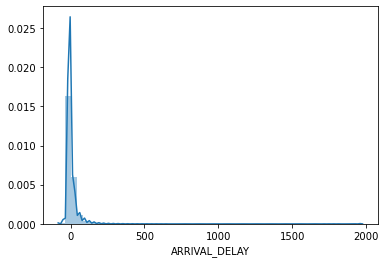

In [13]:
sns.distplot(flights_df['ARRIVAL_DELAY'])

Okay, that's a very dirty distribution. There's a very large extreme there. Let's define our goal of predicting delay to flights with normal length of delays. For this, we need to look at the descriptive statistics of our data.

In [14]:
flights_df['ARRIVAL_DELAY'].describe()

count    573342.000000
mean          4.435855
std          39.293018
min         -80.000000
25%         -13.000000
50%          -5.000000
75%           8.000000
max        1971.000000
Name: ARRIVAL_DELAY, dtype: float64

That's a pretty extreme value there. Let's use the standard deviation method to define outliers. First we need to define our upper and lower bounds using standard deviation and mean.

In [15]:
# calculate summary statistics
data_mean, data_std = flights_df['ARRIVAL_DELAY'].mean(), flights_df['ARRIVAL_DELAY'].std()
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

In [16]:
(lower, upper)

(-113.44319832518022, 122.31490840398135)

Now that we have our lower and upper bounds, we can use those to filter our data. So that we get no extremes.

In [17]:
# Grab values defined inside lower and upper.
flights_df = flights_df.loc[(flights_df['ARRIVAL_DELAY'] >= lower) & (flights_df['ARRIVAL_DELAY'] <= upper)].reset_index().drop(columns=['index'], axis=1)

In [18]:
sns.distplot(flights_df['ARRIVAL_DELAY'])

That's a better looking distribution. It's gaussian-like. Now let's examine the proportion between delayed flights and normal flights!

In [19]:
sns.countplot(x='IS_DELAYED', data=flights_df)

As expected, delayed flights are a minority in the data. Let's keep this in mind when building our models later.

Next, let's see correlation between features. But before that, we need to transform some of the features that we have, so that we can have a better representation of the correlation. For example, see the DEPARTURE/ARRIVAL_TIME and SCHEDULED_DEPARTURE/ARRIVAL features. It is a time of the day value of when the aircraft departed, and when it should've departed. They are kept in a military time format, so let's convert these into a python-friendly format.

But before we can do that, we need to take care of null values in the date. Conversions on NaN wouldn't work in pandas.

In [20]:
missing_df = flights_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(flights_df.shape[0]-missing_df['missing values'])/flights_df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

variable  missing values  filling factor (%)
0   CANCELLATION_REASON          562246            0.000000
1   LATE_AIRCRAFT_DELAY          466345           17.056769
2         AIRLINE_DELAY          466345           17.056769
3        SECURITY_DELAY          466345           17.056769
4      AIR_SYSTEM_DELAY          466345           17.056769
5         WEATHER_DELAY          466345           17.056769
6                  YEAR               0          100.000000
7             CANCELLED               0          100.000000
8              DIVERTED               0          100.000000
9         ARRIVAL_DELAY               0          100.000000
10         ARRIVAL_TIME               0          100.000000
11    SCHEDULED_ARRIVAL               0          100.000000
12              TAXI_IN               0          100.000000
13            WHEELS_ON               0          100.000000
14             DISTANCE               0          100.000000
15             AIR_TIME               0          100.000000
16         ELAPSED_TIME               0          100.000000
17           WHEELS_OFF               0          100.000000
18             TAXI_OUT               0          100.000000
19      DEPARTURE_DELAY               0          100.000000
20       DEPARTURE_TIME               0          100.000000
21  SCHEDULED_DEPARTURE               0          100.000000
22  DESTINATION_AIRPORT               0          100.000000
23       ORIGIN_AIRPORT               0          100.000000
24          TAIL_NUMBER               0          100.000000
25        FLIGHT_NUMBER               0          100.000000
26              AIRLINE               0          100.000000
27          DAY_OF_WEEK               0          100.000000
28                  DAY               0          100.000000
29                MONTH               0          100.000000
30       SCHEDULED_TIME               0          100.000000
31           IS_DELAYED               0          100.000000

Seems like the important features has complete rows. We don't need to drop any rows. We can go ahead and do our transformation with `pd.apply()`

In [21]:
import datetime

def row_tstring(row, mtime):
    if mtime == '2400':
        mtime = '0000'
    
    return datetime.datetime.strptime("{year}-{month}-{day} {hour}:{minute}".format(
        year=row['YEAR'], 
        month=row['MONTH'], 
        day=row['DAY'],
        hour=mtime[0:2],
        minute=mtime[2:]
        ), "%Y-%m-%d %H:%M")

def row_tstring_arrival(row, arrival_value, departure_value):
    arrival = row_tstring(row, arrival_value)
    departure = row_tstring(row, departure_value)
    
    #Add one day if arrival is less than departure
    if(arrival - departure).total_seconds() < 0:
        arrival += datetime.timedelta(days=1)
    
    return arrival

flights_df['DEPARTURE_TIME_TIMESTAMP'] = flights_df.apply(lambda row: row_tstring(row, row['DEPARTURE_TIME']), axis=1)

flights_df['SCHEDULED_DEPARTURE_TIMESTAMP'] = flights_df.apply(lambda row: row_tstring(row, row['SCHEDULED_DEPARTURE']), axis=1)

flights_df['ARRIVAL_TIME_TIMESTAMP'] = flights_df.apply(lambda row: row_tstring_arrival(row, row['ARRIVAL_TIME'], row['DEPARTURE_TIME']), axis=1)

flights_df['SCHEDULED_ARRIVAL_TIMESTAMP'] = flights_df.apply(lambda row: row_tstring_arrival(row, row['SCHEDULED_ARRIVAL'], row['SCHEDULED_DEPARTURE']), axis=1)

flights_df['DEPARTURE_TIME_HOUR'] = flights_df.apply(lambda row: row['DEPARTURE_TIME_TIMESTAMP'].hour, axis=1)
flights_df['SCHEDULED_DEPARTURE_HOUR'] = flights_df.apply(lambda row: row['SCHEDULED_DEPARTURE_TIMESTAMP'].hour, axis=1)

flights_df['ARRIVAL_TIME_HOUR'] = flights_df.apply(lambda row: row['ARRIVAL_TIME_TIMESTAMP'].hour, axis=1)

flights_df['SCHEDULED_ARRIVAL_HOUR'] = flights_df.apply(lambda row: row['SCHEDULED_ARRIVAL_TIMESTAMP'].hour, axis=1)

Now let's select features that makes sense to be visualized as correlation map, and then plot it.

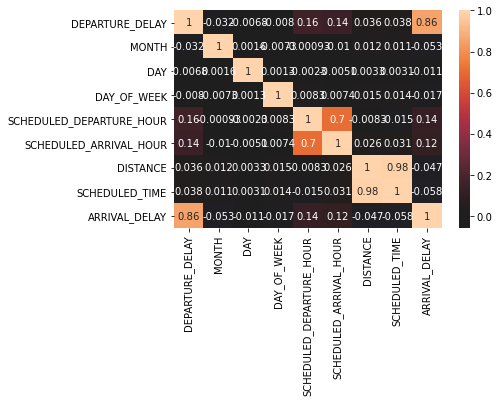

In [22]:
correl_df = flights_df[[
    'DEPARTURE_DELAY',
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'SCHEDULED_DEPARTURE_HOUR',
    'SCHEDULED_ARRIVAL_HOUR',
    'DISTANCE',
    'SCHEDULED_TIME',
    'ARRIVAL_DELAY'
]]

# Compute the correlation matrix
corr = correl_df.corr()
sns.heatmap(corr, annot=True, center=0)

Hmm. . . Pretty low correlation strength observed in these appropriate features and the target predictand, ARRIVAL_DELAY. The strongest correlation is at DEPARTURE_DELAY at 0,86. The rest is worthless to us as predictors. Let's see the relationship between ARRIVAL_DELAY and DEPARTURE_DELAY.

DEPARTURE_DELAY is not a leak, because it's plausible that a stakeholder does their prediction right after the flight has left its' origin airport, hence they would have an information of when the flight depart and therefore the exact value of departure delay.

c:\users\akior\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


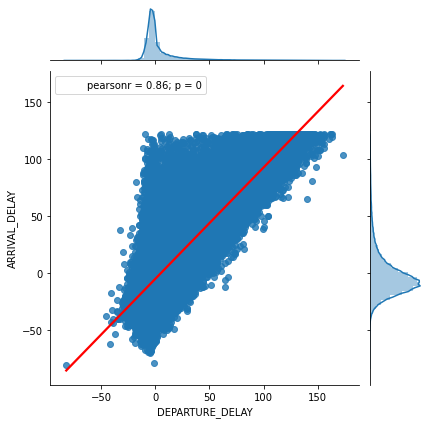

In [23]:
import scipy.stats as stat
sns.jointplot(x=flights_df['DEPARTURE_DELAY'], y=flights_df['ARRIVAL_DELAY'], kind='reg', joint_kws={'line_kws':{'color':'red'}}, stat_func=stat.pearsonr)

As we can see, the correlation of both variables is strongly positive. Let's inspect more.

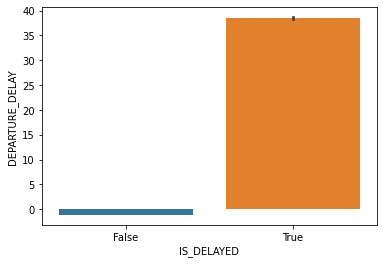

In [24]:
sns.barplot(x='IS_DELAYED', y='DEPARTURE_DELAY', data=flights_df)

From this barplot we can see that higher means in DEPARTURE_DELAY results in arrival delay. That makes sense. But does that mean lower value of DEPARTURE_DELAY are immune to ARRIVAL_DELAY? Let's inspect that.

In [25]:
delay_bound = flights_df.loc[(flights_df['DEPARTURE_DELAY'] >= 5)]

chart = sns.barplot(x=pd.qcut(delay_bound['DEPARTURE_DELAY'], 10), y=delay_bound['IS_DELAYED'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0, 0, '(4.999, 6.0]'),
 Text(0, 0, '(6.0, 9.0]'),
 Text(0, 0, '(9.0, 12.0]'),
 Text(0, 0, '(12.0, 15.0]'),
 Text(0, 0, '(15.0, 20.0]'),
 Text(0, 0, '(20.0, 26.0]'),
 Text(0, 0, '(26.0, 35.0]'),
 Text(0, 0, '(35.0, 48.0]'),
 Text(0, 0, '(48.0, 71.0]'),
 Text(0, 0, '(71.0, 173.0]')]

In [26]:
chart = sns.barplot(x=pd.qcut(delay_bound['DEPARTURE_DELAY'], 10), y=delay_bound['ARRIVAL_DELAY'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0, 0, '(4.999, 6.0]'),
 Text(0, 0, '(6.0, 9.0]'),
 Text(0, 0, '(9.0, 12.0]'),
 Text(0, 0, '(12.0, 15.0]'),
 Text(0, 0, '(15.0, 20.0]'),
 Text(0, 0, '(20.0, 26.0]'),
 Text(0, 0, '(26.0, 35.0]'),
 Text(0, 0, '(35.0, 48.0]'),
 Text(0, 0, '(48.0, 71.0]'),
 Text(0, 0, '(71.0, 173.0]')]

Turns out no. Even with the smallest DEPARTURE_DELAY, there are still some chance that the arrival of the flight is delayed.

As seen from the barplots. It seems that the likelihood of arrival delay rises exponentially as departure delay rises. This feature can make a good predictor for arrival delays.

I have a bit of a hunch for our scheduled departure feature, let's check them out and see what we have.

In [27]:
sns.barplot(x='SCHEDULED_DEPARTURE_HOUR', y='ARRIVAL_DELAY', data=flights_df)

In [28]:
sns.barplot(x='SCHEDULED_DEPARTURE_HOUR', y='IS_DELAYED', data=flights_df)

In [29]:
def cat_hours(hour):
    tod = 'DAY'
    if hour >= 18:
        tod = 'NIGHT'
    
    if hour >= 0 and hour <= 3:
        tod = 'NIGHT'
    
    if hour >= 4 and hour <= 10:
        tod = 'MORNING'
    
    return tod

flights_df["SCHEDULED_DEPARTURE_TIME_OF_DAY"] = flights_df.apply(lambda row: cat_hours(row['SCHEDULED_DEPARTURE_HOUR']), axis=1)
sns.barplot(x='SCHEDULED_DEPARTURE_TIME_OF_DAY', y='IS_DELAYED', order=['MORNING', 'DAY', 'NIGHT'], data=flights_df)

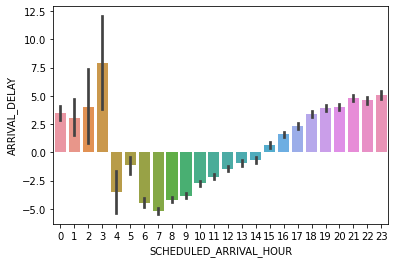

In [30]:
sns.barplot(x='SCHEDULED_ARRIVAL_HOUR', y='ARRIVAL_DELAY', data=flights_df)

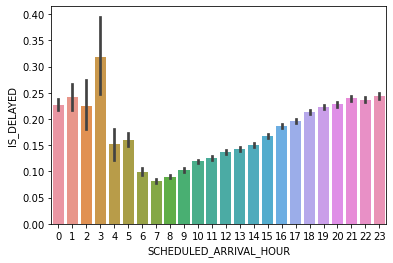

In [31]:
sns.barplot(x='SCHEDULED_ARRIVAL_HOUR', y='IS_DELAYED', data=flights_df)

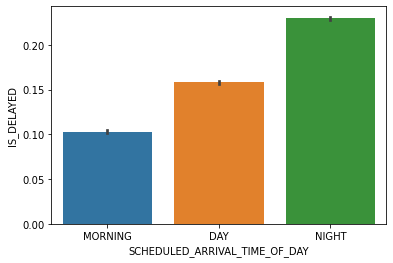

In [32]:
flights_df["SCHEDULED_ARRIVAL_TIME_OF_DAY"] = flights_df.apply(lambda row: cat_hours(row['SCHEDULED_ARRIVAL_HOUR']), axis=1)
sns.barplot(x='SCHEDULED_ARRIVAL_TIME_OF_DAY', y='IS_DELAYED', order=['MORNING', 'DAY', 'NIGHT'], data=flights_df)

Aha! Even though they have a weak correlation to ARRIVAL_DELAY, as we can see here there's some pattern to the data. It seems that there's a major diurnal component to the pattern. Later flights has more chances to be delayed and then it tapers down as it approaches morning.

I think we can finally move on from the numeric features that we have. Now let's see about the categorical features that we have :

- ORIGIN_AIRPORT
- AIRLINE
- DESTINATION_AIRPORT

Let's check out the AIRLINE feature.

[Text(0, 0, 'HA'),
 Text(0, 0, 'AS'),
 Text(0, 0, 'DL'),
 Text(0, 0, 'AA'),
 Text(0, 0, 'OO'),
 Text(0, 0, 'US'),
 Text(0, 0, 'VX'),
 Text(0, 0, 'EV'),
 Text(0, 0, 'WN'),
 Text(0, 0, 'UA'),
 Text(0, 0, 'MQ'),
 Text(0, 0, 'B6'),
 Text(0, 0, 'F9'),
 Text(0, 0, 'NK')]

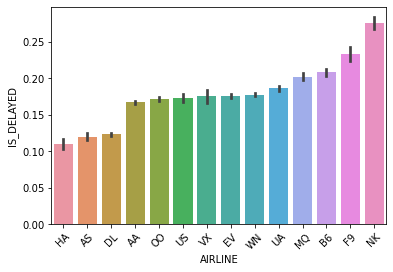

In [33]:
result = flights_df.groupby(['AIRLINE','IS_DELAYED']).count()['FLIGHT_NUMBER'].to_frame().reset_index()
result.columns = ['AIRLINE', 'IS_DELAYED', 'COUNT']
result['likelihood'] = result['COUNT'].div(result.groupby('AIRLINE')['COUNT'].transform(lambda x: x.sum()))
result = result.loc[(result['IS_DELAYED'] == True)]
result = result.sort_values('likelihood')

chart = sns.barplot(x='AIRLINE', y='IS_DELAYED', data=flights_df, order=result['AIRLINE'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

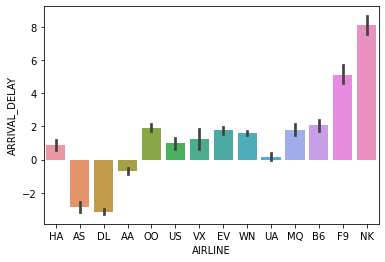

In [34]:
sns.barplot(x='AIRLINE', y='ARRIVAL_DELAY', data=flights_df, order=result['AIRLINE'])

Let's see the distribution of delay minutes per airline!

In [35]:
plt.figure(figsize=(14,50))

for index, airline in enumerate(flights_df['AIRLINE'].unique()):
    plt.subplot(14, 1, index+1)
    sns.distplot(flights_df.loc[(flights_df['AIRLINE'] == airline)]['ARRIVAL_DELAY'])
    plt.title(airline)
    plt.xlabel('')

It seems that each airlines has different percentages of delayed flights. Amongst the delayed flights, the length of delay also varies. Let's check this feature out with our strongest predictor yet, the scheduled departure hour.

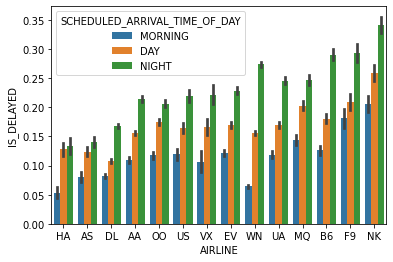

In [36]:
sns.barplot(x='AIRLINE', y='IS_DELAYED', hue='SCHEDULED_ARRIVAL_TIME_OF_DAY', data=flights_df, order=result['AIRLINE'], hue_order=['MORNING', 'DAY', 'NIGHT'])

That's great, even when paired, the pattern generally holds. Morning flights still has the least delay and night flights has the most delays, and the ordering of least to most airline with delays still holds.

Hmm. . . let's go one step further. I want to confirm with the whole flight.

In [37]:
sns.countplot(x='AIRLINE', hue='SCHEDULED_ARRIVAL_TIME_OF_DAY', data=flights_df, order=result['AIRLINE'], hue_order=['MORNING', 'DAY', 'NIGHT'])

I kept the ordering of delay percentage with this plot. It can be seen that the airline with the highest percentage of delays also has one of the least flights in the data. This means that number of flights doesn't necessarily influences the likelihood of flights being delayed.

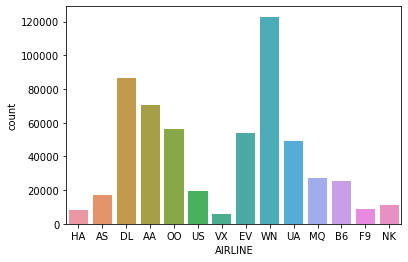

In [38]:
sns.countplot(x='AIRLINE', data=flights_df, order=result['AIRLINE'])

Alright, that is confirmed. This means that number of flights does not necessarily influences how many delays an airline experiences. Meaning that, an airline has more to do with delays happening to it, compared to how many flights it operates.

Let's be skeptical and confirm this one more time. We have the total flights, let's scatter it with delayed percentages, and see what we'll have.

In [39]:
airline_totals = flights_df.groupby(['AIRLINE']).count()['FLIGHT_NUMBER'].to_frame().reset_index()
airline_totals.columns = ['AIRLINE', 'TOTAL_FLIGHTS']

result = pd.merge(result, airline_totals, left_on=['AIRLINE'], right_on=['AIRLINE'], how='left')

c:\users\akior\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


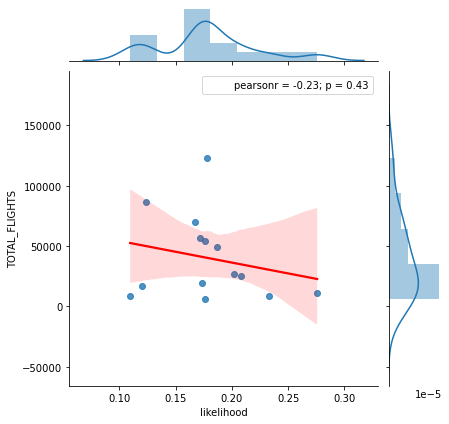

In [40]:
import scipy.stats as stat
p1 = sns.jointplot(x=result['likelihood'], y=result['TOTAL_FLIGHTS'], kind='reg', joint_kws={'line_kws':{'color':'red'}}, stat_func=stat.pearsonr)

Yep, there you go. Only a weak correlation between total flights and likelihood of delayed flights. Of course, if we use number of delayed flights instead of likelihood, the correlation will show a positive. What we're interested in is, how likely an airline experiences a delay, so a likelihood is a better metrics rather than a plain number.

If the likelihood rises as an airline has more flights, it means that delays are truly a function of of total flights. The result that we have shows that delays are more a random process, again.

The P-Value in this test rejects the null hypothesis of the systems being corellated to each other. Which means that if the p-value shows 0.05, the null hypothesis is rejected, and therefore the systems are corellated to each other. We have a p-value of .43, which means there's a high chance that the systems here are not corellated to each other.

Let's check its' relation to ARRIVAL_DELAY now.

[Text(0, 0, 'DL'),
 Text(0, 0, 'AS'),
 Text(0, 0, 'AA'),
 Text(0, 0, 'UA'),
 Text(0, 0, 'HA'),
 Text(0, 0, 'US'),
 Text(0, 0, 'VX'),
 Text(0, 0, 'WN'),
 Text(0, 0, 'EV'),
 Text(0, 0, 'MQ'),
 Text(0, 0, 'OO'),
 Text(0, 0, 'B6'),
 Text(0, 0, 'F9'),
 Text(0, 0, 'NK')]

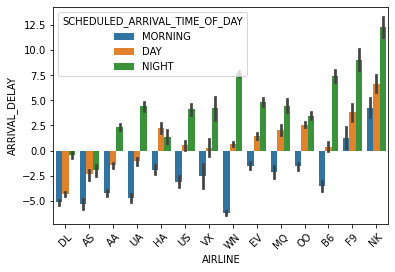

In [41]:
result_mins = flights_df.groupby(['AIRLINE']).mean()['ARRIVAL_DELAY'].to_frame().reset_index()
result_mins.columns = ['AIRLINE', 'ARRIVAL_DELAY_MEAN']
result_mins = result_mins.sort_values('ARRIVAL_DELAY_MEAN')

chart = sns.barplot(x='AIRLINE', y='ARRIVAL_DELAY', hue='SCHEDULED_ARRIVAL_TIME_OF_DAY', data=flights_df, order=result_mins['AIRLINE'], hue_order=['MORNING', 'DAY', 'NIGHT'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [42]:
result_mins = pd.merge(result_mins, airline_totals, left_on=['AIRLINE'], right_on=['AIRLINE'], how='left')

c:\users\akior\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


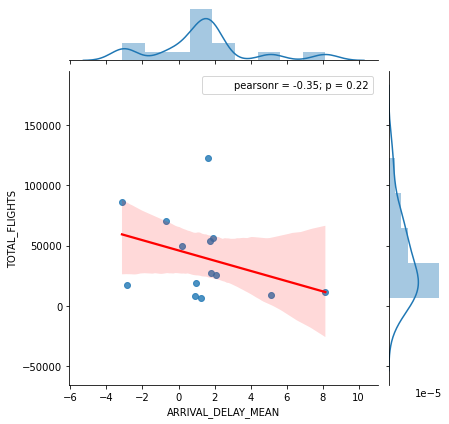

In [43]:
sns.jointplot(x=result_mins['ARRIVAL_DELAY_MEAN'], y=result_mins['TOTAL_FLIGHTS'], kind='reg', joint_kws={'line_kws':{'color':'red'}}, stat_func=stat.pearsonr)

It seems that the same also applies for ARRIVAL_DELAY. The rank changes a bit, but generally it has the same effect.

Let's investigate the airports feature! There are a lot of airports in the data, so it's not wise to display them all. Let's just display the top 10 of it. 

[Text(0, 0, 'ATL'),
 Text(0, 0, 'ORD'),
 Text(0, 0, 'DFW'),
 Text(0, 0, 'DEN'),
 Text(0, 0, 'LAX'),
 Text(0, 0, 'SFO'),
 Text(0, 0, 'PHX'),
 Text(0, 0, 'IAH'),
 Text(0, 0, 'LAS'),
 Text(0, 0, 'MSP'),
 Text(0, 0, 'SEA'),
 Text(0, 0, 'DTW'),
 Text(0, 0, 'MCO'),
 Text(0, 0, 'BOS'),
 Text(0, 0, 'CLT'),
 Text(0, 0, 'EWR'),
 Text(0, 0, 'SLC'),
 Text(0, 0, 'LGA'),
 Text(0, 0, 'JFK'),
 Text(0, 0, 'BWI')]

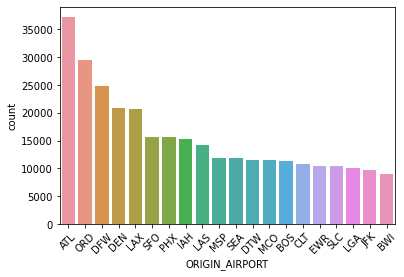

In [44]:
orig_result = flights_df.groupby(['ORIGIN_AIRPORT']).count()['FLIGHT_NUMBER'].to_frame().reset_index()
orig_result.columns = ['ORIGIN_AIRPORT', 'COUNT']

orig_delays = flights_df.groupby(['ORIGIN_AIRPORT', 'IS_DELAYED']).count()['FLIGHT_NUMBER'].to_frame().reset_index()
orig_delays.columns = ['ORIGIN_AIRPORT', 'IS_DELAYED', 'COUNT']
orig_delays['likelihood'] = orig_delays['COUNT'].div(orig_delays.groupby('ORIGIN_AIRPORT')['COUNT'].transform(lambda x: x.sum()))
orig_delays = orig_delays.loc[(orig_delays['IS_DELAYED'] == True)]

orig_delays = orig_delays.drop(columns=['IS_DELAYED'])
orig_delays.columns = ['ORIGIN_AIRPORT', 'DELAY_COUNT', 'DELAY_LIKELIHOOD']

orig_delays_min = flights_df.groupby(['ORIGIN_AIRPORT']).mean()['ARRIVAL_DELAY'].to_frame().reset_index()
orig_delays_min.columns = ['ORIGIN_AIRPORT', 'DELAY_MEAN']

orig_result = pd.merge(orig_result, orig_delays, left_on=['ORIGIN_AIRPORT'], right_on=['ORIGIN_AIRPORT'], how='left')
orig_result = pd.merge(orig_result, orig_delays_min, left_on=['ORIGIN_AIRPORT'], right_on=['ORIGIN_AIRPORT'], how='left')

chart = sns.countplot(x='ORIGIN_AIRPORT', data=flights_df, order=orig_result
              .sort_values('COUNT', ascending=False)['ORIGIN_AIRPORT'][:20])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0, 0, 'HYA'),
 Text(0, 0, 'AKN'),
 Text(0, 0, 'MMH'),
 Text(0, 0, 'ADK'),
 Text(0, 0, 'UST'),
 Text(0, 0, 'GST'),
 Text(0, 0, 'ILG'),
 Text(0, 0, 'PPG'),
 Text(0, 0, 'PBG'),
 Text(0, 0, 'BPT'),
 Text(0, 0, 'EGE'),
 Text(0, 0, 'LBE'),
 Text(0, 0, 'HPN'),
 Text(0, 0, 'MKG'),
 Text(0, 0, 'STX'),
 Text(0, 0, 'BRD'),
 Text(0, 0, 'CRW'),
 Text(0, 0, 'MTJ'),
 Text(0, 0, 'LGA'),
 Text(0, 0, 'ORD')]

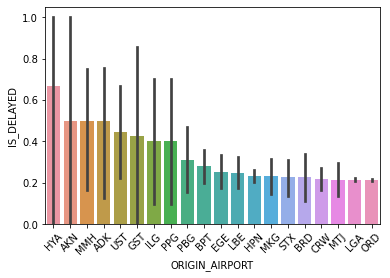

In [45]:
chart = sns.barplot(x='ORIGIN_AIRPORT', y='IS_DELAYED', data=flights_df, order=orig_result
              .sort_values('DELAY_LIKELIHOOD', ascending=False)['ORIGIN_AIRPORT'][:20])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0, 0, 'MMH'),
 Text(0, 0, 'GST'),
 Text(0, 0, 'UST'),
 Text(0, 0, 'AKN'),
 Text(0, 0, 'STC'),
 Text(0, 0, 'ILG'),
 Text(0, 0, 'ADK'),
 Text(0, 0, 'HYA'),
 Text(0, 0, 'PPG'),
 Text(0, 0, 'BPT'),
 Text(0, 0, 'PIB'),
 Text(0, 0, 'CRW'),
 Text(0, 0, 'DAL'),
 Text(0, 0, 'BET'),
 Text(0, 0, 'BTR'),
 Text(0, 0, 'DHN'),
 Text(0, 0, 'OAK'),
 Text(0, 0, 'HOU'),
 Text(0, 0, 'BFL'),
 Text(0, 0, 'MOB')]

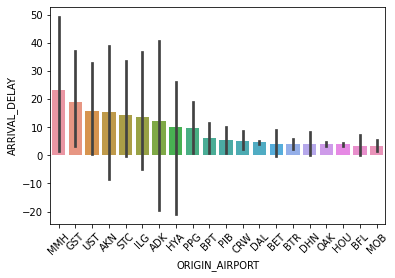

In [46]:
chart = sns.barplot(x='ORIGIN_AIRPORT', y='ARRIVAL_DELAY', data=flights_df, order=orig_result
              .sort_values('DELAY_MEAN', ascending=False)['ORIGIN_AIRPORT'][:20])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

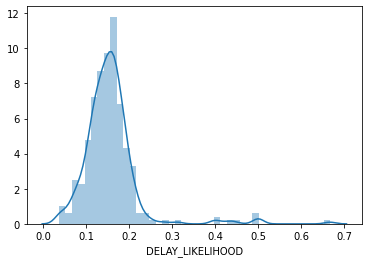

In [47]:
sns.distplot(orig_result['DELAY_LIKELIHOOD'])

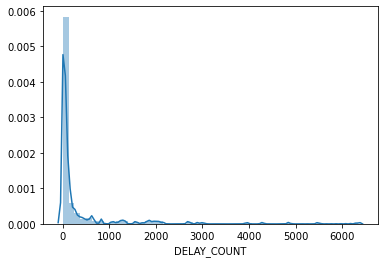

In [48]:
sns.distplot(orig_result['DELAY_COUNT'])

In [49]:
sns.distplot(orig_result['COUNT'])

In [50]:
sns.distplot(orig_result['COUNT'])

c:\users\akior\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


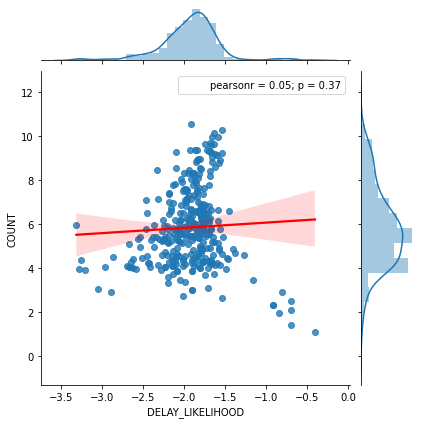

In [51]:
sns.jointplot(x=np.log(orig_result['DELAY_LIKELIHOOD']), y=np.log(orig_result['COUNT']), kind='reg', joint_kws={'line_kws':{'color':'red'}}, stat_func=stat.pearsonr)

Okay, it seems like an airport has its' own likelihood of delay, different from one another. Some even went as high as 0.6-ish. I also investigated its relation to total operating flights, which as seen, there's no strong relation.

Let's check the same with destination airport.

In [52]:
dest_result = flights_df.groupby(['DESTINATION_AIRPORT']).count()['FLIGHT_NUMBER'].to_frame().reset_index()
dest_result.columns = ['DESTINATION_AIRPORT', 'COUNT']

dest_delays = flights_df.groupby(['DESTINATION_AIRPORT', 'IS_DELAYED']).count()['FLIGHT_NUMBER'].to_frame().reset_index()
dest_delays.columns = ['DESTINATION_AIRPORT', 'IS_DELAYED', 'COUNT']
dest_delays['likelihood'] = dest_delays['COUNT'].div(dest_delays.groupby('DESTINATION_AIRPORT')['COUNT'].transform(lambda x: x.sum()))
dest_delays = dest_delays.loc[(dest_delays['IS_DELAYED'] == True)]

dest_delays = dest_delays.drop(columns=['IS_DELAYED'])
dest_delays.columns = ['DESTINATION_AIRPORT', 'DELAY_COUNT', 'DELAY_LIKELIHOOD']

dest_result = pd.merge(dest_result, dest_delays, left_on=['DESTINATION_AIRPORT'], right_on=['DESTINATION_AIRPORT'], how='left')

chart = sns.countplot(x='DESTINATION_AIRPORT', data=flights_df, order=dest_result
              .sort_values('COUNT', ascending=False)['DESTINATION_AIRPORT'][:20])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

[Text(0, 0, 'ATL'),
 Text(0, 0, 'ORD'),
 Text(0, 0, 'DFW'),
 Text(0, 0, 'LAX'),
 Text(0, 0, 'DEN'),
 Text(0, 0, 'SFO'),
 Text(0, 0, 'PHX'),
 Text(0, 0, 'IAH'),
 Text(0, 0, 'LAS'),
 Text(0, 0, 'SEA'),
 Text(0, 0, 'MSP'),
 Text(0, 0, 'MCO'),
 Text(0, 0, 'DTW'),
 Text(0, 0, 'BOS'),
 Text(0, 0, 'CLT'),
 Text(0, 0, 'SLC'),
 Text(0, 0, 'EWR'),
 Text(0, 0, 'LGA'),
 Text(0, 0, 'JFK'),
 Text(0, 0, 'BWI')]

[Text(0, 0, 'OTH'),
 Text(0, 0, 'CEC'),
 Text(0, 0, 'HYA'),
 Text(0, 0, 'ADK'),
 Text(0, 0, 'IAG'),
 Text(0, 0, 'PBG'),
 Text(0, 0, 'GST'),
 Text(0, 0, 'ILG'),
 Text(0, 0, 'BQN'),
 Text(0, 0, 'MMH'),
 Text(0, 0, 'PSE'),
 Text(0, 0, 'ASE'),
 Text(0, 0, 'JLN'),
 Text(0, 0, 'BPT'),
 Text(0, 0, 'SCE'),
 Text(0, 0, 'LAW'),
 Text(0, 0, 'TTN'),
 Text(0, 0, 'ITH'),
 Text(0, 0, 'STC'),
 Text(0, 0, 'MQT')]

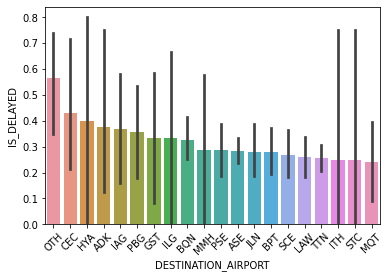

In [53]:
chart = sns.barplot(x='DESTINATION_AIRPORT', y='IS_DELAYED', data=flights_df, order=dest_result
              .sort_values('DELAY_LIKELIHOOD', ascending=False)['DESTINATION_AIRPORT'][:20])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

c:\users\akior\appdata\local\programs\python\python36\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


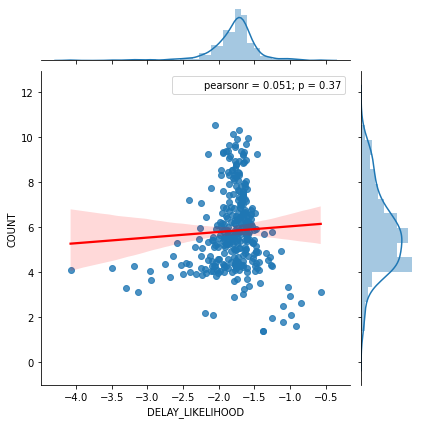

In [54]:
sns.jointplot(x=np.log(dest_result['DELAY_LIKELIHOOD']), y=np.log(dest_result['COUNT']), kind='reg', joint_kws={'line_kws':{'color':'red'}}, stat_func=stat.pearsonr)

Well, turns out, it's more or less the same. Though it does have a different rankings of delay likelihood. This can be helpful for our model.

I think we've done enough requisite scouting and analysis at this point. Let's review what we have so far so that we can mimic what we do in Spark.

Data Manipulation steps :

- Drop nulls
- Clean outliers based on standard deviation method


Selected Features :

- DEPARTURE_DELAY
- Departure hour
    - Derive from SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL by taking first two characters.
- AIRLINE
    - Rank airlines by delay, and turn into ordinal feature
- ORIGIN and DESTINATION AIRPORT
    - Rank airports by delay, and turn into ordinal feature.

We also need to address the severe imbalance between delayed and non-delayed flights. Since we already have about 6 Million rows, we can go head and to undersampling on the majority. This means that we sample non-delayed flights with less rows to balanced with our delayed flights.

Now that we have everything we need from pandas, we can move back to PySpark. Let's do so. I won't be showing the result of each codeblock, because it will take long for each of them to show. The `.show()` method is a collection method, so everything we did will be executed up to that point to show the result.

First let's drop some nulls, and select the features we want.


In [55]:
from pyspark.sql.functions import isnan, when, count, col

flight_sdf = spark.sql('select ARRIVAL_DELAY, DEPARTURE_DELAY, SCHEDULED_DEPARTURE, SCHEDULED_ARRIVAL, AIRLINE, \
ORIGIN_AIRPORT, DESTINATION_AIRPORT \
from flights where \
SCHEDULED_DEPARTURE IS NOT NULL \
AND SCHEDULED_ARRIVAL IS NOT NULL \
AND DEPARTURE_DELAY IS NOT NULL \
AND AIRLINE IS NOT NULL \
AND ORIGIN_AIRPORT IS NOT NULL \
AND DESTINATION_AIRPORT IS NOT NULL')
flight_sdf.createOrReplaceTempView('flights')

Now let's drop the outliers!

In [56]:
dd_stats = spark.sql('select avg(ARRIVAL_DELAY) as mean, stddev(ARRIVAL_DELAY) as std from flights').collect()
data_mean = dd_stats[0]['mean']
data_std = dd_stats[0]['std']
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# lower = -30
# upper = 30

flights_sdf = spark.sql('select * from flights where ARRIVAL_DELAY >= {lower} AND ARRIVAL_DELAY <= {upper}'
                        .format(lower=lower, upper=upper))
flights_sdf.createOrReplaceTempView('flights')

In [57]:
flights_sdf = spark.sql('select \
*, \
CASE \
WHEN ARRIVAL_DELAY >= 15 THEN 1 \
ELSE 0 \
END AS DELAY_15 \
from flights')
flights_sdf.createOrReplaceTempView('flights')

Next we'll extract departure hour by taking the first two characters from SCHEDULED_DEPARTURE

In [58]:
flights_sdf = spark.sql('select \
*, \
CASE \
WHEN CAST(SUBSTRING(SCHEDULED_DEPARTURE, 0, 2) AS INT) = 24 THEN 0 \
ELSE CAST(SUBSTRING(SCHEDULED_DEPARTURE, 0, 2) AS INT) \
END AS SCHEDULED_DEPARTURE_HOUR \
from flights')
flights_sdf.createOrReplaceTempView('flights')

flights_sdf = spark.sql('select \
*, \
CASE \
WHEN CAST(SUBSTRING(SCHEDULED_ARRIVAL, 0, 2) AS INT) = 24 THEN 0 \
ELSE CAST(SUBSTRING(SCHEDULED_ARRIVAL, 0, 2) AS INT) \
END AS SCHEDULED_ARRIVAL_HOUR \
from flights')
flights_sdf.createOrReplaceTempView('flights')

That was way quicker than what we did in pandas. Let's move on.

Now that's taken care of, we can move on to the AIRLINE part. Let's aggregate their DEPARTURE_DELAY first.

In [59]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import *

airlines_mean = spark.sql("SELECT AIRLINE, AVG(ARRIVAL_DELAY) as ARRIVAL_DELAY_MEAN FROM flights GROUP BY AIRLINE order by AVG(ARRIVAL_DELAY)")
airlines_mean = airlines_mean.withColumn("AIRLINE_ORDINAL", row_number().over(Window.orderBy("ARRIVAL_DELAY_MEAN")))
airlines_mean.createOrReplaceTempView('airlines_ordinal')

Now join the result with our main table

In [60]:
spark.sql("SELECT f.*, \
ao.AIRLINE_ORDINAL FROM flights f join airlines_ordinal ao on ao.AIRLINE = f.AIRLINE").createOrReplaceTempView('flights')

That's done. Now we need to move on to the airports. The aggregation is the same so this should be quick.

In [61]:
origins_mean = spark.sql("SELECT ORIGIN_AIRPORT, AVG(ARRIVAL_DELAY) as ARRIVAL_DELAY_MEAN FROM flights GROUP BY ORIGIN_AIRPORT order by AVG(ARRIVAL_DELAY)")
origins_mean = origins_mean.withColumn("ORIGIN_ORDINAL", row_number().over(Window.orderBy("ARRIVAL_DELAY_MEAN")))
origins_mean.createOrReplaceTempView('origins_ordinal')

destinations_mean = spark.sql("SELECT DESTINATION_AIRPORT, AVG(ARRIVAL_DELAY) as ARRIVAL_DELAY_MEAN FROM flights GROUP BY DESTINATION_AIRPORT order by AVG(ARRIVAL_DELAY)")
destinations_mean = destinations_mean.withColumn("DESTINATION_ORDINAL", row_number().over(Window.orderBy("ARRIVAL_DELAY_MEAN")))
destinations_mean.createOrReplaceTempView('destinations_ordinal')

In [62]:
#Strange workaround necessary to avoid the "missing resolved attributes" exception
#Refer to https://issues.apache.org/jira/browse/SPARK-14948
c = spark.sql("SELECT * FROM flights").columns
fsdf = spark.sql("SELECT * FROM flights").toDF(*c)
fsdf.createOrReplaceTempView("flights")

spark.sql("SELECT f.*, \
origins_ordinal.ORIGIN_ORDINAL FROM flights f join origins_ordinal on origins_ordinal.ORIGIN_AIRPORT = f.ORIGIN_AIRPORT").createOrReplaceTempView("flights")

#Strange workaround necessary to avoid the "missing resolved attributes" exception
#Refer to https://issues.apache.org/jira/browse/SPARK-14948
c = spark.sql("SELECT * FROM flights").columns
fsdf = spark.sql("SELECT * FROM flights").toDF(*c)
fsdf.createOrReplaceTempView("flights")

spark.sql("SELECT f.*, \
do.DESTINATION_ORDINAL FROM flights f join destinations_ordinal do on do.DESTINATION_AIRPORT = f.DESTINATION_AIRPORT").createOrReplaceTempView('flights')

dataset = spark.sql("SELECT DELAY_15, SCHEDULED_DEPARTURE_HOUR, SCHEDULED_ARRIVAL_HOUR, AIRLINE_ORDINAL, ORIGIN_ORDINAL, DESTINATION_ORDINAL, DEPARTURE_DELAY FROM flights")

In [63]:
dataset.count()

5618474

We now have our complete dataset. We can begin our modelling process! First, we need to index our label properly so that the model works better, and then we need to assemble the features into a vector.

In [64]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import PCA
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder


labelIndexer = StringIndexer().setInputCol("DELAY_15").setOutputCol("indexedLabel").fit(dataset)
dataset = labelIndexer.transform(dataset)

features = ('SCHEDULED_DEPARTURE_HOUR', 'AIRLINE_ORDINAL', 'ORIGIN_ORDINAL', 'DESTINATION_ORDINAL', 'SCHEDULED_ARRIVAL_HOUR', 'DEPARTURE_DELAY')
assembler = VectorAssembler(inputCols=features,outputCol="features")

dataset=assembler.transform(dataset)

Now that we have our features set, we have to split the data into test and training. Let's have 30% of the data for testing, and have the rest for training.

In [65]:
from pyspark.sql.functions import col, explode, array, lit
#Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])

We also need to undersample the majority class (Normal Flights) to address the class imbalance. All we need to do is to resample the majority with a desired ratio and plug that back into the training data.

In [66]:
# Undersampling on trainingData
major_df = trainingData.filter(col("indexedLabel") == 0)
minor_df = trainingData.filter(col("indexedLabel") == 1)

ratio = int(major_df.count()/minor_df.count())

sampled_majority_df = major_df.sample(False, 1/ratio)
trainingData = sampled_majority_df.unionAll(minor_df)
# print("ratio: {}".format(ratio))

And then we can go ahead and train the model! Let's do 100 trees with random forest. We then evaluate the result with ROC metrics

In [67]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=100)
model = rf.fit(trainingData)

# # Make predictions.
predictions = model.transform(testData)

# # Select (prediction, true label) and compute test error
# evaluator = BinaryClassificationEvaluator(
#     labelCol="indexedLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
# accuracy = evaluator.evaluate(predictions)
# print("areaUnderROC %s" % str(accuracy))

from pyspark.mllib.evaluation import BinaryClassificationMetrics
# Compute raw scores on the test set
preds = predictions.select('indexedLabel','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['indexedLabel'])))
# Instantiate metrics object
metrics = BinaryClassificationMetrics(preds)

In [72]:
metrics.areaUnderROC

0.9031170812753321

A 89% score is great! Considering that all we see on the data proves that delal is more or less a random process. Let's sample the prediction result and look at how it performs.

In [68]:
pred_df = predictions.sample(False, 0.1, 42)
pred_df = pred_df.toPandas()

In [69]:
pred_df_tidy = pred_df.drop(columns=['features'])
pred_df_tidy

DELAY_15  SCHEDULED_DEPARTURE_HOUR  SCHEDULED_ARRIVAL_HOUR  \
0              0                        13                      15   
1              0                        13                      15   
2              0                        13                      15   
3              0                        15                      16   
4              0                        15                      17   
...          ...                       ...                     ...   
169096         1                        21                      22   
169097         1                        22                      23   
169098         1                        22                      23   
169099         1                        22                      23   
169100         1                        22                      23   

        AIRLINE_ORDINAL  ORIGIN_ORDINAL  DESTINATION_ORDINAL  DEPARTURE_DELAY  \
0                    11             162                  110               -9   
1                    11             162                  110               -3   
2                    11             162                  110               -3   
3                    11             162                  110                0   
4                    11             162                  110               -3   
...                 ...             ...                  ...              ...   
169096               12             303                  322               -1   
169097               12             270                  167               31   
169098               12             270                  167               45   
169099               12             303                  154               11   
169100               12             303                  154               23   

        indexedLabel                            rawPrediction  \
0                0.0   [83.74994773049109, 16.25005226950892]   
1                0.0   [83.74994773049109, 16.25005226950892]   
2                0.0   [83.74994773049109, 16.25005226950892]   
3                0.0  [82.81903693145152, 17.180963068548472]   
4                0.0  [82.81903693145152, 17.180963068548472]   
...              ...                                      ...   
169096           1.0  [83.17789206279939, 16.822107937200606]   
169097           1.0    [7.975050817623228, 92.0249491823768]   
169098           1.0    [7.975050817623228, 92.0249491823768]   
169099           1.0   [64.60522448036639, 35.39477551963359]   
169100           1.0    [7.96945303168931, 92.03054696831073]   

                                      probability  prediction  
0        [0.8374994773049109, 0.1625005226950892]         0.0  
1        [0.8374994773049109, 0.1625005226950892]         0.0  
2        [0.8374994773049109, 0.1625005226950892]         0.0  
3       [0.8281903693145152, 0.17180963068548472]         0.0  
4       [0.8281903693145152, 0.17180963068548472]         0.0  
...                                           ...         ...  
169096  [0.8317789206279939, 0.16822107937200606]         0.0  
169097  [0.07975050817623226, 0.9202494918237677]         1.0  
169098  [0.07975050817623226, 0.9202494918237677]         1.0  
169099    [0.6460522448036641, 0.353947755196336]         0.0  
169100  [0.07969453031689307, 0.9203054696831069]         1.0  

[169101 rows x 11 columns]

To see how the model does, we can plot a confusion matrix.

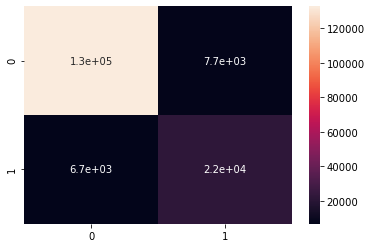

In [70]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(pred_df_tidy['indexedLabel'],pred_df_tidy['prediction'])
sns.heatmap(cf_matrix, annot=True)

As we can see, the model predicts true positive for delays a lot more than it does for false positives and false negatives combined. It does still less than twice of those two. Let's see how the learning curve looks!

In [81]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

pred_df_tidy['probability_normal'] = pred_df_tidy.apply(lambda row: row['probability'][0], axis=1)
pred_df_tidy['probability_delayed'] = pred_df_tidy.apply(lambda row: row['probability'][1], axis=1)
ns_fpr, ns_tpr, _ = roc_curve(pred_df_tidy['indexedLabel'], [0 for _ in range(len(pred_df_tidy))])
lr_fpr, lr_tpr, _ = roc_curve(pred_df_tidy['indexedLabel'], pred_df_tidy['probability_delayed'])
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

It looks good. Sampled prediction result gets about 0.8 to 0.9. But here's the catch, ROC does not perform well for class imbalances, remember that we have an imbalanced number of delayed flights to non-delayed flights. For that, we need to check out the prediction's Precision-Recall! Let's see how our model performs on this metrics.

In [82]:
metrics.areaUnderPR

0.7830986084988435

In [85]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

lr_precision, lr_recall, _ = precision_recall_curve(pred_df_tidy['indexedLabel'], pred_df_tidy['probability_delayed'])
lr_f1, lr_auc = f1_score(pred_df_tidy['indexedLabel'], pred_df_tidy['prediction']), auc(lr_recall, lr_precision)
# summarize scores
print('Random Forest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
no_skill = len(pred_df_tidy.loc[pred_df_tidy['indexedLabel'] == 1]) / len(pred_df_tidy)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Random Forest: f1=0.754 auc=0.781


Okay, it seems that our model performs worse for f1, and precision-recall AUC metrics. However, they do perform correctly. The curve does shaped like a normal model does. No mis-classing, and even the imbalance effect looks dampened in the plot. Looks like the resampling did something good. Here's the summary of every score of the model, in a nifty pandas dataframe.

In [87]:
pd.DataFrame(data={
    'ROC_AUC':[metrics.areaUnderROC],
    'PR_AUC':[metrics.areaUnderPR],
    'Sampled_f1_Score':[f1_score(pred_df_tidy['indexedLabel'], pred_df_tidy['prediction'])]
})

ROC_AUC    PR_AUC  Sampled_f1_Score
0  0.903117  0.783099          0.753601

Alright. Usually when we have our spark pipeline fixed, we need to submit the code into some Spark service on a better server. So we need to rewrite our Spark codeblocks into a pipeline. Here's the full pipeline based on what we have done. Let's stop our previous spark service first, so that we free up some resources.

In [97]:
spark.stop()

Next let's rewrite our spark codeblocks. As with the previous codeblocks, we won't use any `show()` method, because it's unnecessary at this stage. The block also assume that we are ready to implement modelling steps from the previous experiments, so we don't need to test for performance anymore.

In [131]:
spark.stop()

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import row_number
from pyspark.sql.window import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import PCA
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline, Transformer
from pyspark.sql.functions import col, explode, array, lit
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql import DataFrame
from pyspark.ml.pipeline import Estimator, Model, Pipeline
from pyspark.ml.param.shared import *
from pyspark.sql.functions import avg, stddev_samp
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable 
from pyspark import keyword_only 

#I pressed shift+Enter a lot, so this would prevent the cell from running
# raise Exception("NotReady!!!")

#Change these directories to somewhere more approproate for your environment
MODEL_SAVEDIR='G:/asyst/DelayPrediction/model_pipeline'
SPARK_TEMP_DIR='file:///G:/temp'
DATA_DIR='G:/asyst/DelayPrediction/'

"""
Custom Transformers and Estimators
"""
class BinaryUnderSampler(Transformer):
    """
    A custom Transformer which undersamples major class label (0).
    """

    def __init__(self, label_col='indexedLabel'):
        super(BinaryUnderSampler, self).__init__()
        self.label_col = label_col

    def _transform(self, df: DataFrame) -> DataFrame:
        major_df = df.filter(col(self.label_col) == 0)
        minor_df = df.filter(col(self.label_col) == 1)
        ratio = int(major_df.count()/minor_df.count())
        sampled_majority_df = major_df.sample(False, 1/ratio)
        return sampled_majority_df.unionAll(minor_df)

class BinaryDelayTransformer(Transformer):
    """
    Transforms a minute delay into a binary class
    """
    def __init__(self, delay_col, output_col='DELAY_15'):
        super(BinaryDelayTransformer, self).__init__()
        self.delay_col = delay_col
        self.output_col = output_col
    
    def _transform(self, df: DataFrame) -> DataFrame:
        df.createOrReplaceTempView('bd_work')
        df = spark.sql('select \
        *, \
        CASE \
        WHEN {delay_col} >= 15 THEN 1 \
        ELSE 0 \
        END AS {output_col} \
        from bd_work'.format(delay_col=self.delay_col, output_col=self.output_col))
        return df

class AirportsFixer(Transformer):
    """
    Fixes bad airport codes
    """
    def __init__(self, airports_id, airports_iata):
        super(AirportsFixer, self).__init__()
        self.airports_id = airports_id
        self.airports_iata = airports_iata
    
    def _transform(self, df: DataFrame) -> DataFrame:
        self.airports_id.createOrReplaceTempView('af_airports_id')
        self.airports_iata.createOrReplaceTempView('af_iata')
        df.createOrReplaceTempView('af_work_1')
        
        spark.sql('select \
        aid.Code as id, \
        iata.code as iata_code, \
        aid.Description as description \
        from af_airports_id aid \
        left join af_iata iata on iata.description = aid.description').createOrReplaceTempView('af_airports_master')
        
        spark.sql("select f.*, \
        oam.iata_code as ORIGIN_AIRPORT_FIXED, \
        dam.iata_code as DESTINATION_AIRPORT_FIXED \
        from af_work_1 f \
        left join af_airports_master oam on oam.id = f.ORIGIN_AIRPORT \
        left join af_airports_master dam on dam.id = f.DESTINATION_AIRPORT").createOrReplaceTempView('af_work_2')
        
        spark.sql("SELECT YEAR, \
        MONTH, \
        DAY, \
        DAY_OF_WEEK, \
        AIRLINE, \
        FLIGHT_NUMBER, \
        TAIL_NUMBER, \
        CASE \
        WHEN ORIGIN_AIRPORT_FIXED IS NOT NULL THEN ORIGIN_AIRPORT_FIXED \
        ELSE ORIGIN_AIRPORT \
        END AS ORIGIN_AIRPORT, \
        CASE \
        WHEN DESTINATION_AIRPORT_FIXED IS NOT NULL THEN DESTINATION_AIRPORT_FIXED \
        ELSE DESTINATION_AIRPORT \
        END AS DESTINATION_AIRPORT, \
        SCHEDULED_DEPARTURE, \
        DEPARTURE_TIME, \
        DEPARTURE_DELAY, \
        TAXI_OUT, \
        WHEELS_OFF, \
        SCHEDULED_TIME, \
        ELAPSED_TIME, \
        AIR_TIME, \
        DISTANCE, \
        WHEELS_ON, \
        TAXI_IN, \
        SCHEDULED_ARRIVAL, \
        ARRIVAL_TIME, \
        ARRIVAL_DELAY, \
        DIVERTED, \
        CANCELLED, \
        CANCELLATION_REASON, \
        AIR_SYSTEM_DELAY, \
        SECURITY_DELAY, \
        AIRLINE_DELAY, \
        LATE_AIRCRAFT_DELAY, \
        WEATHER_DELAY, DELAY_15 FROM af_work_2").createOrReplaceTempView('af_work_3')
        
        df = spark.sql('select ARRIVAL_DELAY, DEPARTURE_DELAY, SCHEDULED_DEPARTURE, SCHEDULED_ARRIVAL, AIRLINE, \
        ORIGIN_AIRPORT, DESTINATION_AIRPORT, DIVERTED, CANCELLED, DELAY_15 \
        from af_work_3 where \
        SCHEDULED_DEPARTURE IS NOT NULL \
        AND SCHEDULED_ARRIVAL IS NOT NULL \
        AND DEPARTURE_DELAY IS NOT NULL \
        AND AIRLINE IS NOT NULL \
        AND ORIGIN_AIRPORT IS NOT NULL \
        AND DESTINATION_AIRPORT IS NOT NULL \
        AND DIVERTED IS NOT NULL \
        AND CANCELLED IS NOT NULL \
        AND DELAY_15 IS NOT NULL')
        return df

class FlightDataCleanser(Transformer):
    """
    Cleanse flight data
    """
    def __init__(self):
        super(FlightDataCleanser, self).__init__()
    
    def _transform(self, df: DataFrame) -> DataFrame:
        df.createOrReplaceTempView('fdc_work')
        df = spark.sql("select * from fdc_work where DIVERTED = 0 and CANCELLED = 0")
        return df

class ExtractHoursFromMilitaryTime(Transformer, HasInputCol, 
                                   HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    """
    Takes hours from military time formats
    """
    
    @keyword_only
    def __init__(self, inputCol=None, outputCol='hrs_transformed'):
        super(ExtractHoursFromMilitaryTime, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
    
    @keyword_only
    def setParams(self, inputCol=None, outputCol='hrs_transformed'):
        """
        Sets params for this SetValueTransformer.
        """
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, df: DataFrame) -> DataFrame:
        df.createOrReplaceTempView('hh_work')
        df = spark.sql('select \
        *, \
        CASE \
        WHEN CAST(SUBSTRING({input_col}, 0, 2) AS INT) = 24 THEN 0 \
        ELSE CAST(SUBSTRING({input_col}, 0, 2) AS INT) \
        END AS {output_col} \
        from hh_work'.format(input_col=self.getInputCol(), output_col=self.getOutputCol()))
        return df

class HasCatDictionary(Params):
    catDict = Param(Params._dummy(), "catDict", "Dictionary from categorical feature to ordinal feature")
    
    def __init__(self):
        super(HasCatDictionary, self).__init__()

    def setMean(self, value):
        return self._set(catDict=value)

    def getCatDict(self):
        return self.getOrDefault(self.catDict)

class HasCatRank(Params):
    catRank = Param(Params._dummy(), "catRank", "List of categorical feature ordered", typeConverter=TypeConverters.toListString)
    
    def __init__(self):
        super(HasCatRank, self).__init__()

    def setCatRank(self, value):
        return self._set(catRank=value)

    def getCatRank(self):
        return self.getOrDefault(self.catRank)
    
    def getCatRankDF(self):
        return spark.createDataFrame([(index + 1, val) for index, val in enumerate(self.getCatRank())], ['rank', 'cat'])
        

class Cat2OrdinalModel(Model, HasInputCol, HasPredictionCol, HasCatRank, DefaultParamsReadable, DefaultParamsWritable):
    @keyword_only
    def __init__(self, inputCol=None, catRank=None, predictionCol="ordinal_transformed"):
        super(Cat2OrdinalModel, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
    
    @keyword_only
    def setParams(self, inputCol=None, catRank=None, predictionCol="ordinal_transformed"):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, df):
        self.getCatRankDF().createOrReplaceTempView('cto_work_ranks')
        df.createOrReplaceTempView('cto_work_input')
        df = spark.sql(
            "SELECT a.*, b.rank as {predictionCol} from cto_work_input a \
            join cto_work_ranks b on \
            b.cat = a.{inputCol}".format(inputCol=self.getInputCol(), predictionCol=self.getPredictionCol())
        )
        return df

class Cat2Ordinal(Estimator):
    """
    Transforms a categorical feature to an ordinal (ranked) feature
    Defaults on mean aggregation.
    """
    AGGR_DICT = {
        'AVG':'AVG',
        'SUM':'SUM'
    }
    
    def __init__(self, aggrCol=None, inputCol=None, outputCol='ordinal_transformed', aggr='AVG'):
        super(Cat2Ordinal, self).__init__()
        self.aggrCol = aggrCol
        self.inputCol = inputCol
        self.outputCol = outputCol
        self.aggr_sql = self.get_aggr_sql(aggr)
    
    def get_aggr_sql(self, aggr_string):
        return self.AGGR_DICT[aggr_string]
    
    def aggregate(self, df):
        df.createOrReplaceTempView('aggr_work')
        df = spark.sql("SELECT {inputCol} as cat, \
        {aggr_sql}({aggrCol}) as aggr \
        FROM aggr_work \
        GROUP BY {inputCol} order by AVG({aggrCol})".format(aggr_sql=self.aggr_sql, 
                                                            inputCol=self.inputCol, 
                                                            aggrCol=self.aggrCol))
        return [str(row.cat) for row in df.collect()]
    
    def _fit(self, df):
        rank = self.aggregate(df)
        return Cat2OrdinalModel(
            inputCol=self.inputCol,
            catRank=rank,
            predictionCol=self.outputCol
        )
#Change this to something that fits the environment
spark = SparkSession.builder.config("spark.sql.warehouse.dir", SPARK_TEMP_DIR).appName("FlightDelay").getOrCreate()

#Change the location of these files to where you put it
flights_sdf = spark.read.option("header",True).schema('YEAR integer, MONTH integer, DAY integer, DAY_OF_WEEK integer, AIRLINE string, FLIGHT_NUMBER string, \
TAIL_NUMBER string, ORIGIN_AIRPORT string, DESTINATION_AIRPORT string, SCHEDULED_DEPARTURE string, DEPARTURE_TIME string, \
DEPARTURE_DELAY integer, TAXI_OUT integer, WHEELS_OFF string, SCHEDULED_TIME integer, ELAPSED_TIME string, AIR_TIME integer, \
DISTANCE integer, WHEELS_ON string, TAXI_IN integer, SCHEDULED_ARRIVAL string, ARRIVAL_TIME string, ARRIVAL_DELAY integer, \
DIVERTED integer, CANCELLED integer, CANCELLATION_REASON string, AIR_SYSTEM_DELAY integer, SECURITY_DELAY integer, \
AIRLINE_DELAY integer, LATE_AIRCRAFT_DELAY integer, WEATHER_DELAY integer').csv("{ddir}/flights.csv".format(ddir=DATA_DIR))

airports_id = spark.read.option("header",True).csv("{ddir}/L_AIRPORT_ID.csv".format(ddir=DATA_DIR))
airports_iata = spark.read.option("header",True).csv("{ddir}/L_AIRPORT.csv".format(ddir=DATA_DIR))

#Prep Pipeline
"""
This pipeline should not be included in the final implementation.
This is only used for training.
"""
prep_pipeline = Pipeline(stages=[
    BinaryDelayTransformer(delay_col='ARRIVAL_DELAY'),
    BinaryUnderSampler(label_col='DELAY_15'),
    AirportsFixer(airports_id, airports_iata),
    FlightDataCleanser()
])
prep = prep_pipeline.fit(flights_sdf)
dataset = prep.transform(flights_sdf)

#Training Pipeline
"""
This pipeline assumes that the data it's receiving has the same shape as the data from the Prep Pipeline.
The pipeline foregoes any testing because at this point it's assumed that this is no longer an experiment,
but an implementation pipeline.
"""
fe_pipeline = Pipeline(stages=[
    ExtractHoursFromMilitaryTime(inputCol='SCHEDULED_DEPARTURE', outputCol='SCHEDULED_DEPARTURE_HOUR'),
    ExtractHoursFromMilitaryTime(inputCol='SCHEDULED_ARRIVAL', outputCol='SCHEDULED_ARRIVAL_HOUR'),
    Cat2Ordinal(aggrCol='ARRIVAL_DELAY', inputCol='AIRLINE', outputCol='AIRLINE_ORDINAL'),
    Cat2Ordinal(aggrCol='ARRIVAL_DELAY', inputCol='ORIGIN_AIRPORT', outputCol='ORIGIN_ORDINAL'),
    Cat2Ordinal(aggrCol='ARRIVAL_DELAY', inputCol='DESTINATION_AIRPORT', outputCol='DESTINATION_ORDINAL'),
    StringIndexer().setInputCol("DELAY_15").setOutputCol("indexedLabel"),
    VectorAssembler(
        inputCols=('SCHEDULED_DEPARTURE_HOUR', 'AIRLINE_ORDINAL', 'ORIGIN_ORDINAL', 'DESTINATION_ORDINAL', 'SCHEDULED_ARRIVAL_HOUR', 'DEPARTURE_DELAY'), 
        outputCol="features"),
    RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=100)
])

model = fe_pipeline.fit(dataset)
model.save(MODEL_SAVEDIR)

spark.stop()

Above codeblock should be able to be submitted into any compatible Spark 3.0.0 cluster as long as it can access any data it needs.

# Key Takeaways

This concludes the experiment of Spark 3.0.0. There are a couple of important takeaways that I learned from this experiment.

## A Data Scientist's Workflow

When dealing with a large amount of data (probably >= 4 mil rows) using Spark, a data scientist's workflow goes like so :

### Experimentation
This phase is done to figure out how to build a best machine learning model for the case.

#### Requisite loading and cleaning with Spark
The data scientist loads the data in its' entirety into the spark cluster. At this stage, the data scientist looks for data imperfection, such as incorrect data types or any imperfection that would impact the data analysis stage. It's not impossible for this stage to be repeated in the future when the data scientist finds more imperfection as the data analysis progresses.

#### Data Analysis with Pandas
Data Analysis with Spark is difficult and awkward. Though they have a functional DataFrame interface, it is not as robust as what Pandas has. It is more efficient for a data scientist to do their analysis in Pandas instead. To do this, the data scientist can sample some data from the spark cluster. The analysis is then done on the smaller sample size. This is done for Feature Selection and figuring out Feature Engineering steps. Maybe even to figure out some data elimination steps.

#### Pre-Modelling with Pandas + Sklearn
I find that it's maybe more ideal to do a preliminary modelling on the smaller sample size with sklearn. The data scientist can do a grid search (coupled with cross validation if the sample is too small), to find the best model and its hyperparameters. 

#### Steps Mirroring with Spark
Once a general pipeline is figured out from the steps before using the smaller sample, the data scientist can then mirror what they do using Spark. Split the data into training and test to see how the model performs. If it performs worse than expected, repeat the experimentation phase, until the model performs well.

### Implementation
This phase is done to deploy the model.

#### Pipeline Building
With every steps that has been figured out from the previous phase, a pipeline is built according to the steps. The codeblocks in this phase is a bit different from the experimentation phase. Everything must be in a form of Estimators, Transformers, and Pipeline. Every stages in the pipeline must be able to be serialized.

#### Deploy
Once the pipeline is built and serialized, the model pipeline can be deployed as an API Microservice. The microservice has to have access to a Spark cluster. This way, any other microservices that needs the ML prediction can obtain prediction result through the API.

## Flight Delay : A Random Process*
From the analysis done to the data, it is found that the delay event is pretty much a random process, from the point of view of the current data. The only strong predictor to arrival delay is departure delay, which in itself is a delay event. Any other features does not have a strong corellation to delay events.

There are some relation and pattern between scheduled departure/arrival hours with delay event, but it might has something to do with how numbers of flight also fluctuates with day and night.

Long story short, using the current data for delay prediction is very unsuitable, because it boils down to pure chance. Predicting departure delay will be very difficult with the current data.

### Improvements
In order to improve the model, the following can be done.

#### Chained Flight Delay Prediction
It is known that there's a strong correlation between arrival delay and departure delay. If there is some way to know which flight precedes each flights, then we can predict departure delay by seeing whether or not the previous flight arrives delayed.

#### Data Enrichment
In order properly predict delays, an information about the airport condition is necessary. These can be in form of :

- Airport's capacity
- Airport's flight per hour
- Weather information
- Holiday information
- Special Events (Bomb threats, accidents, etc)